In [647]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [648]:
df = pd.read_csv('house-pricing-data.csv')

In [649]:
print(df.head())

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


In [650]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None


In [651]:
print(df.isnull().sum())

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


Inference: No NULL values.

Convert categorical data to boolean one-hot encoding.

In [652]:
df[['mainroad', 'guestroom', 'basement','hotwaterheating','airconditioning', 'prefarea']] = df[['mainroad', 'guestroom', 'basement','hotwaterheating','airconditioning', 'prefarea']].map(lambda x: {'yes': 1, 'no': 0}.get(x));
df[['furnishingstatus']] = df[['furnishingstatus']].map(lambda x: {'semi-furnished': 1, 'unfurnished': 0, 'furnished': 2}.get(x));

In [653]:
print(df.head())

      price  area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  13300000  7420         4          2        3         1          0   
1  12250000  8960         4          4        4         1          0   
2  12250000  9960         3          2        2         1          0   
3  12215000  7500         4          2        2         1          0   
4  11410000  7420         4          1        2         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1        2         1   
1         0                0                1        3         0   
2         1                0                0        2         1   
3         1                0                1        3         1   
4         1                0                1        2         0   

   furnishingstatus  
0                 2  
1                 2  
2                 1  
3                 2  
4                 2  


# EDA #

<Figure size 1000x600 with 0 Axes>

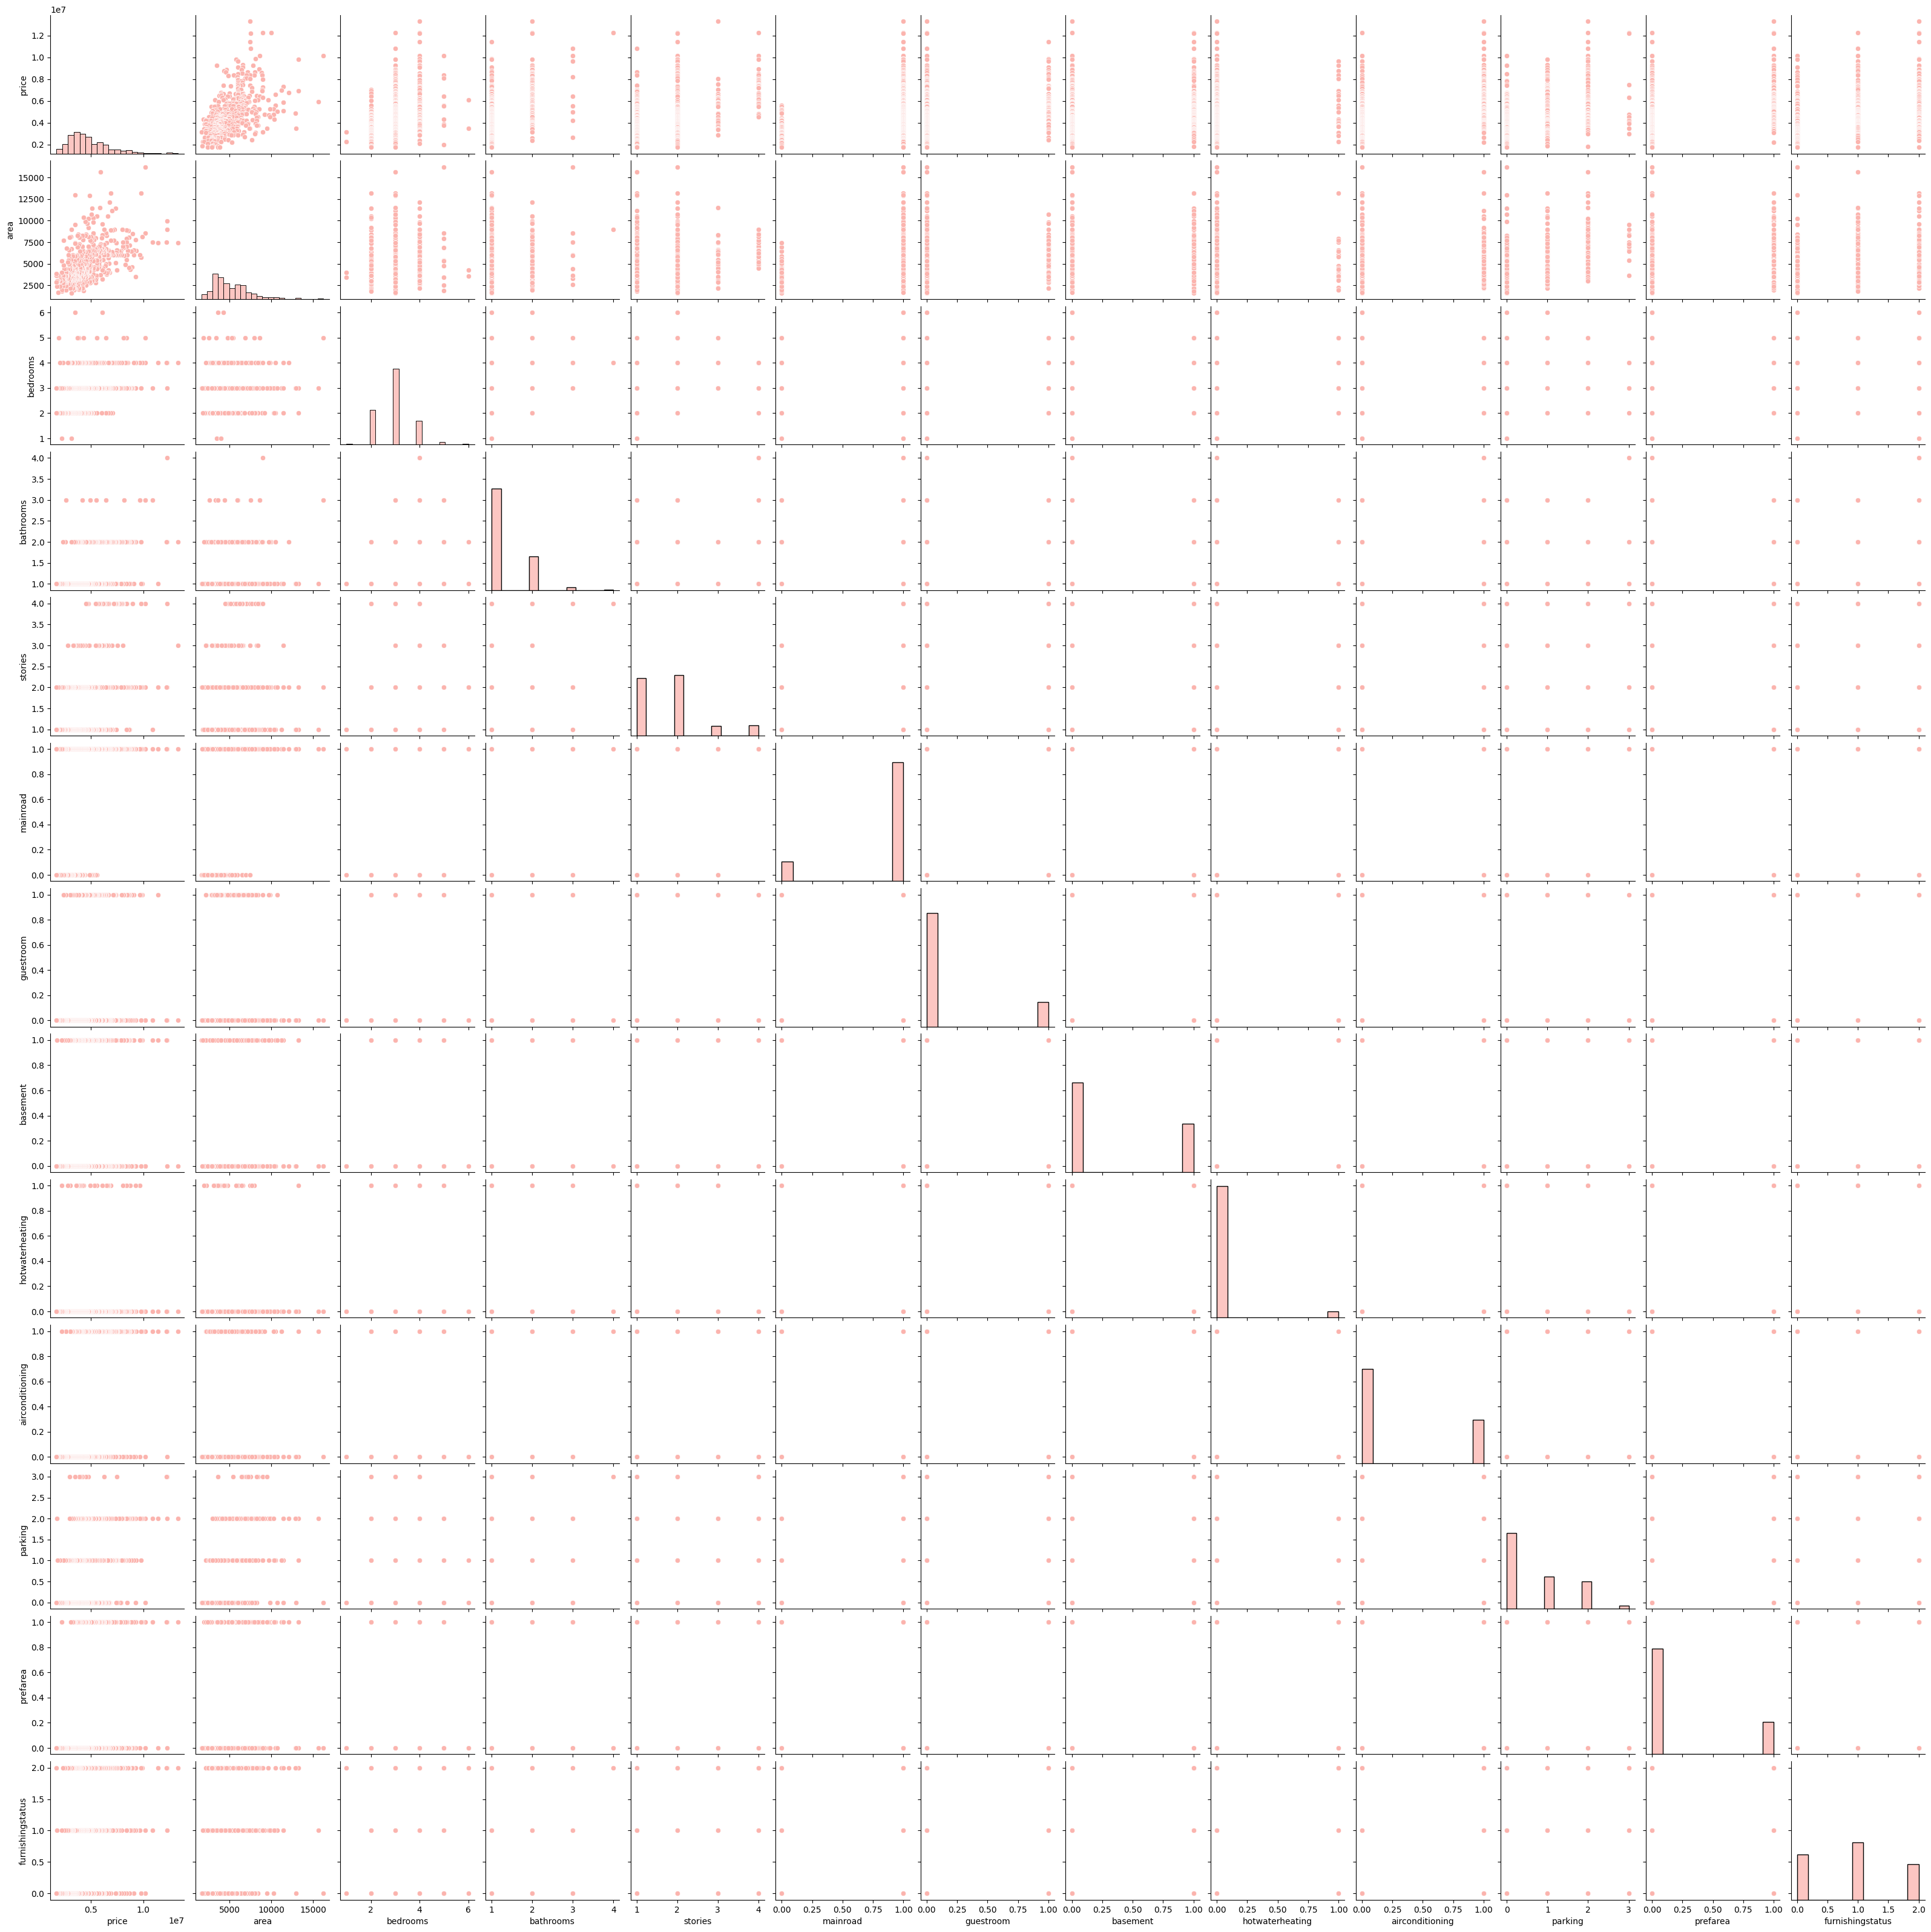

In [654]:
sns.set_palette("Pastel1") 
plt.figure(figsize=(10, 6)) 
  
sns.pairplot(df) 
  
plt.show() 

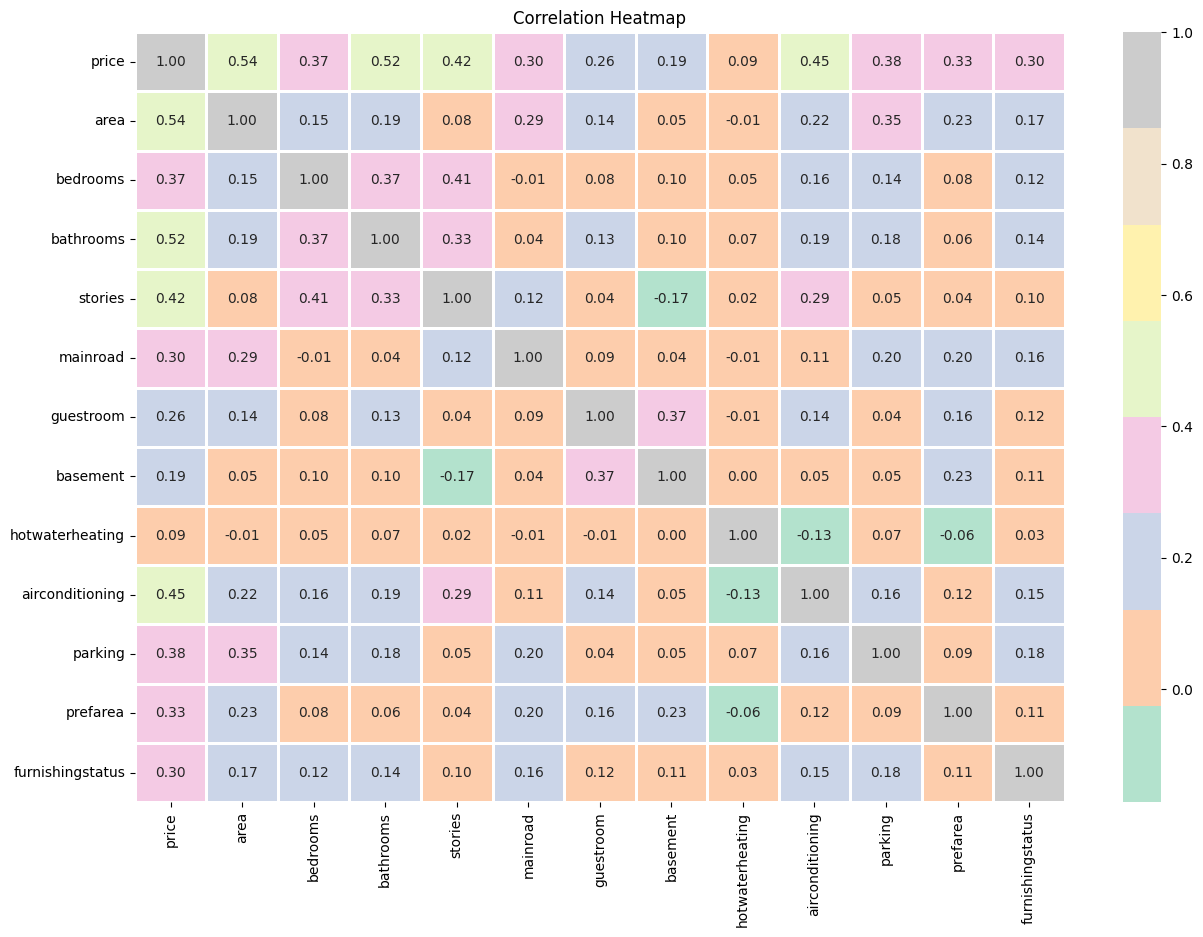

In [655]:
plt.figure(figsize=(15, 10)) 

sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2) 

plt.title('Correlation Heatmap') 
plt.show() 

In [656]:
df[['price', 'area']] = (df[['price', 'area']] - df[['price', 'area']].min()) / (df[['price', 'area']].max() - df[['price', 'area']].min())
print(df.head())

      price      area  bedrooms  bathrooms  stories  mainroad  guestroom  \
0  1.000000  0.396564         4          2        3         1          0   
1  0.909091  0.502405         4          4        4         1          0   
2  0.909091  0.571134         3          2        2         1          0   
3  0.906061  0.402062         4          2        2         1          0   
4  0.836364  0.396564         4          1        2         1          1   

   basement  hotwaterheating  airconditioning  parking  prefarea  \
0         0                0                1        2         1   
1         0                0                1        3         0   
2         1                0                0        2         1   
3         1                0                1        3         1   
4         1                0                1        2         0   

   furnishingstatus  
0                 2  
1                 2  
2                 1  
3                 2  
4                 2  


## Data Preprocessing ##

In [657]:
targets = torch.tensor(df['price'].to_numpy(), dtype=torch.float32)
feature_cols = df.columns.tolist()[1:]
features = torch.tensor(df[feature_cols].to_numpy(), dtype=torch.float32)
print(targets.shape)
print(features.shape)

torch.Size([545])
torch.Size([545, 12])


In [658]:
class HousePriceDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        item = {
            'features': self.features[idx],
            'target': self.targets[idx]
        }
        return item

In [659]:
train_indices, test_indices = train_test_split(range(len(features)), test_size=0.2, random_state=22)
train_indices, val_indices = train_test_split(train_indices, test_size=0.1, random_state=22)

In [660]:
train_dataset = HousePriceDataset(features[train_indices], targets[train_indices])
val_dataset = HousePriceDataset(features[val_indices], targets[val_indices])
test_dataset = HousePriceDataset(features[test_indices], targets[test_indices])

batch_size = 24

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Neural Network Model ##

In [661]:
class PredModel(nn.Module):
    def __init__(self, hidden_size):
        super(PredModel, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(12, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.seq(x)

In [688]:
def train(model, device, train_loader, optimiser, epoch):
    train_losses = []
    val_losses = []
    model.to(device)
    
    model.train()
    
    for epoch in tqdm(range(epoch)):
    # for epoch in range(epoch):
        total_train_loss = 0
        train_count = 0
        total_val_loss = 0
        val_count = 0
        
        for batch in train_loader:
            inputs, targets = batch['features'], batch['target'].unsqueeze(1)
            
        
            optimiser.zero_grad()
            outputs = model(inputs)
            
            train_loss = criterion(outputs, targets)
            train_loss.backward()
            optimiser.step()
            
            total_train_loss += train_loss.item()
            train_count += 1
            
        with torch.no_grad():
            for batch in train_loader:
                inputs, targets = batch['features'], batch['target'].unsqueeze(1)
                outputs = model(inputs)
                
                val_loss = criterion(outputs, targets)
                
                total_val_loss += val_loss.item()
                val_count += 1
                
        train_losses.append(total_train_loss/train_count)
        val_losses.append(total_val_loss/val_count)
    
    plt.semilogy(train_losses)
    plt.semilogy(val_losses)
    plt.legend(["Train loss", "Val. loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

# Accuracy within 1% of actual value
def test(model, device, test_loader):
    model.to(device)
    
    correct, total = 0, 0
    model.eval()
    
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch['features'], batch['target'].unsqueeze(1)
            
            predicted = model(inputs)
            
            percentage_error = torch.abs((predicted - targets) / targets) * 100

            correct += torch.sum(percentage_error < 1).item()
            total += targets.size(0)
            
    acc = round(100 * correct / total, 1)
    return acc
                

In [663]:
model = PredModel(hidden_size=50)
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cpu")
# device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

nepoch = 300

  0%|          | 0/300 [00:00<?, ?it/s]

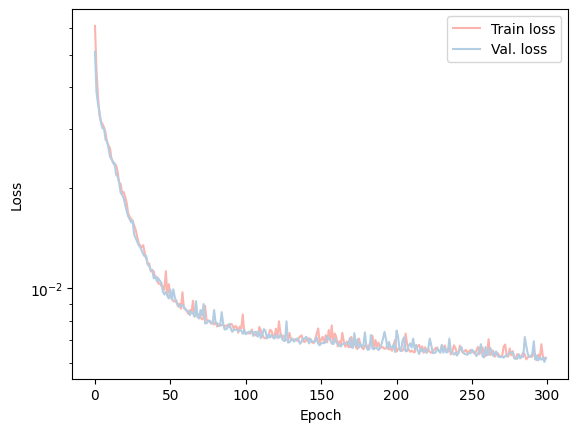

In [664]:
train(model, device, train_loader, optimiser, nepoch)

In [689]:
acc = test(model, device, test_loader)
print(f"Accuracy: {acc}%")

Accuracy: 1.8%
